# Arc Lamp Bright Lines

Simple notebook to extract the bright lines from the arc lamps at several fixed wavelengths and plot them for one or more exposures.

In [1]:
import os
import json
import fitsio

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=14)

## Fixed Wavelengths

Define fixed wavelengths for the most prominent lines in the arc lamps. These were defined using the script

```
python find_arclines.py \
    -n 20230104 \
    -i /global/cfs/cdirs/desi/spectro/nightwatch/nersc
    -o arclines.json
```

In [3]:
calarcs = {
    'CALIB short Arcs all': {
        'wavelength' : {
            'B': [4048.0, 4360.0, 4679.0, 4801.0, 5087.0, 5462.0],
            'R': [6145.0, 6385.0, 6404.0, 6508.0, 6680.0, 6931.0, 7034.0, 7247.0, 7604.0],
            'Z': [7604.0, 8115.0, 8192.0, 8266.0, 8301.0, 8779.0, 8822.0, 8931.0]
        }
    },
    'CALIB long Arcs Cd+Xe': {
        'wavelength' : {
            'B': [3612.0, 4679.0, 4801.0, 5087.0],
            'R': [6440.0],
            'Z': [8234.0, 8283.0, 8822.0, 8955.0, 9048.0, 9165.0, 9802.0],
        }
    }
}

calarcs

{'CALIB short Arcs all': {'wavelength': {'B': [4048.0,
    4360.0,
    4679.0,
    4801.0,
    5087.0,
    5462.0],
   'R': [6145.0,
    6385.0,
    6404.0,
    6508.0,
    6680.0,
    6931.0,
    7034.0,
    7247.0,
    7604.0],
   'Z': [7604.0, 8115.0, 8192.0, 8266.0, 8301.0, 8779.0, 8822.0, 8931.0]}},
 'CALIB long Arcs Cd+Xe': {'wavelength': {'B': [3612.0,
    4679.0,
    4801.0,
    5087.0],
   'R': [6440.0],
   'Z': [8234.0, 8283.0, 8822.0, 8955.0, 9048.0, 9165.0, 9802.0]}}}

## Plotting Function(s)

In [4]:
def plot_arc_lines(datadir, night, expids, sp, prog, wavelengths):
    """Plot bright lines from the arc lamps.
    
    Parameters
    ----------
    datadir : str
        Path to Nightwatch qframe outputs (datadir/YYYYMDD/EXPID).
    night : int
        Night with exposures of interest (YYYYMMDD).
    expids : list
        List of ints giving exposures of interest.
    sp : int
        Spectrograph [0-9].
    prog : str
        Calibration program, e.g., 'CALIB short Arcs all'.
    wavelengths : dict
        Dictionary of lines for the B, R, and Z cameras.
    
    Returns
    -------
    linepeqws : dict
        Quick calculation of line pseudo-equivalent widths.
    """
    colors = { 'B' : 'royalblue', 'R' : 'green', 'Z' : 'r' }
    figp = { 'B' : None, 'R' : None, 'Z' : None }
    linepeqws = { }
    
    for expid in expids:
        for cam in colors:
            qframe = os.path.join(datadir, f'{night}', f'{expid:08d}', f'qframe-{cam.lower()}{sp}-{expid:08d}.fits')
            if not os.path.exists(qframe):
                raise FileNotFoundError(qframe)
            
            h = fitsio.read_header(qframe, ext='FIBERMAP')
            prog = h['PROGRAM']
            arclines = wavelengths[cam]
            nlines = len(arclines)

            fits = fitsio.FITS(qframe)
            wave = np.median(fits['WAVELENGTH'][240:260, :], axis=0)
            flux = np.median(fits['FLUX'][240:260, :], axis=0)
            
            if figp[cam] is None:
                ncol, nrow = 4, int(np.ceil(nlines / 3))
                fig, axpks = plt.subplots(nrow, ncol, figsize=(4*ncol, 4*nrow), tight_layout=True)
                axpks = axpks.flatten()
                figp[cam] = [fig, axpks]
            else:
                fig, axpks = figp[cam]
                
            for arcline, axpk in zip(arclines, axpks):
                pk = np.argmin(np.abs(wave - arcline))
                i = np.maximum(pk-12,0)
                j = np.minimum(pk+12, len(wave)-1)

                axpk.scatter(wave[i:j], flux[i:j], color=colors[cam],alpha=0.5)
                axpk.plot(wave[i:j], flux[i:j], color=colors[cam], alpha=0.5, ls='--')
                axpk.set(title=f'{arcline:.1f} $\AA$')

                peqw = np.trapz(flux[i:j], wave[i:j])
                print(f'{wave[pk]:8.1f} {peqw:10.1f}')
                
                if arcline in linepeqws:
                    linepeqws[arcline].append(peqw)
                else:
                    linepeqws[arcline] = [peqw]

            if len(axpks) > nlines:
                for k in range(nlines, len(axpks)):
                    axpks[k].set_visible(False)
        print()

    return linepeqws

## Short Arcs

### Data from 20230104

  4047.9    12879.5
  4359.9    26447.6
  4679.0     6051.1
  4800.8    15690.7
  5086.9    21044.1
  5462.1    42557.4
  6145.2    25005.4
  6385.3    29227.2
  6403.9    55266.1
  6508.2    31075.1
  6680.0    26358.0
  6931.0    26979.3
  7034.1   108680.8
  7246.8    49205.0
  7603.8    29803.6
  7604.2    39881.3
  8114.9   113919.3
  8192.0    28023.4
  8265.8    30050.7
  8300.7    51610.4
  8779.0    59044.7
  8821.9    31892.0
  8930.8    41240.6

  4047.9    13482.7
  4359.9    26967.4
  4679.0     6467.1
  4800.8    16024.9
  5086.9    21206.6
  5462.1    44240.3
  6145.2    24949.4
  6385.3    29251.7
  6403.9    55205.2
  6508.2    31031.2
  6680.0    26328.9
  6931.0    26730.1
  7034.1   108988.7
  7246.8    49279.2
  7603.8    29832.8
  7604.2    40155.8
  8114.9   103888.0
  8192.0    27802.8
  8265.8    26354.0
  8300.7    51605.0
  8779.0    58871.7
  8821.9    31880.7
  8930.8    41251.7

  4047.9    13831.0
  4359.9    27250.5
  4679.0     6540.7
  4800.8    15893.

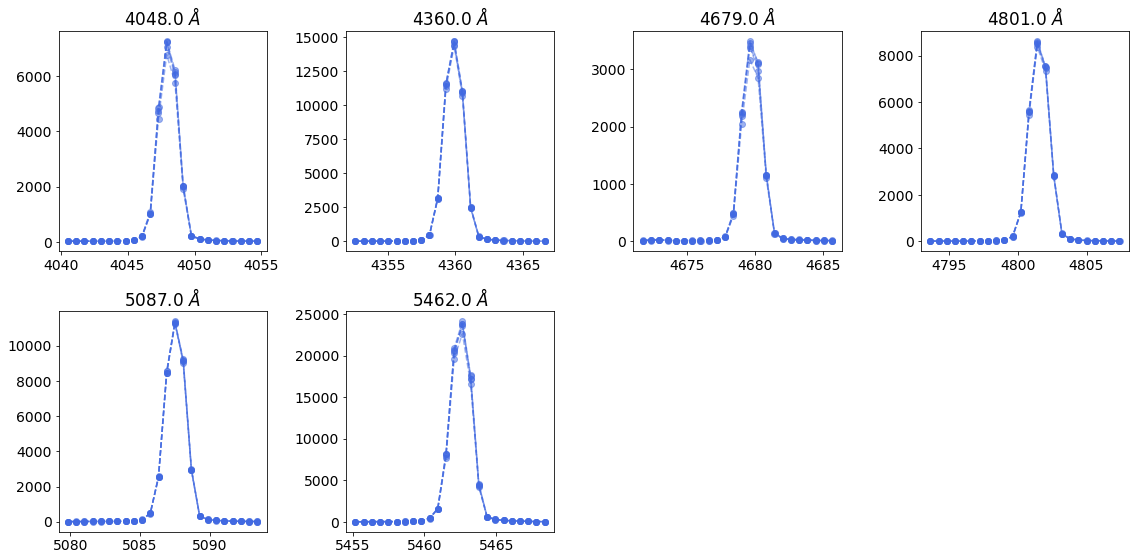

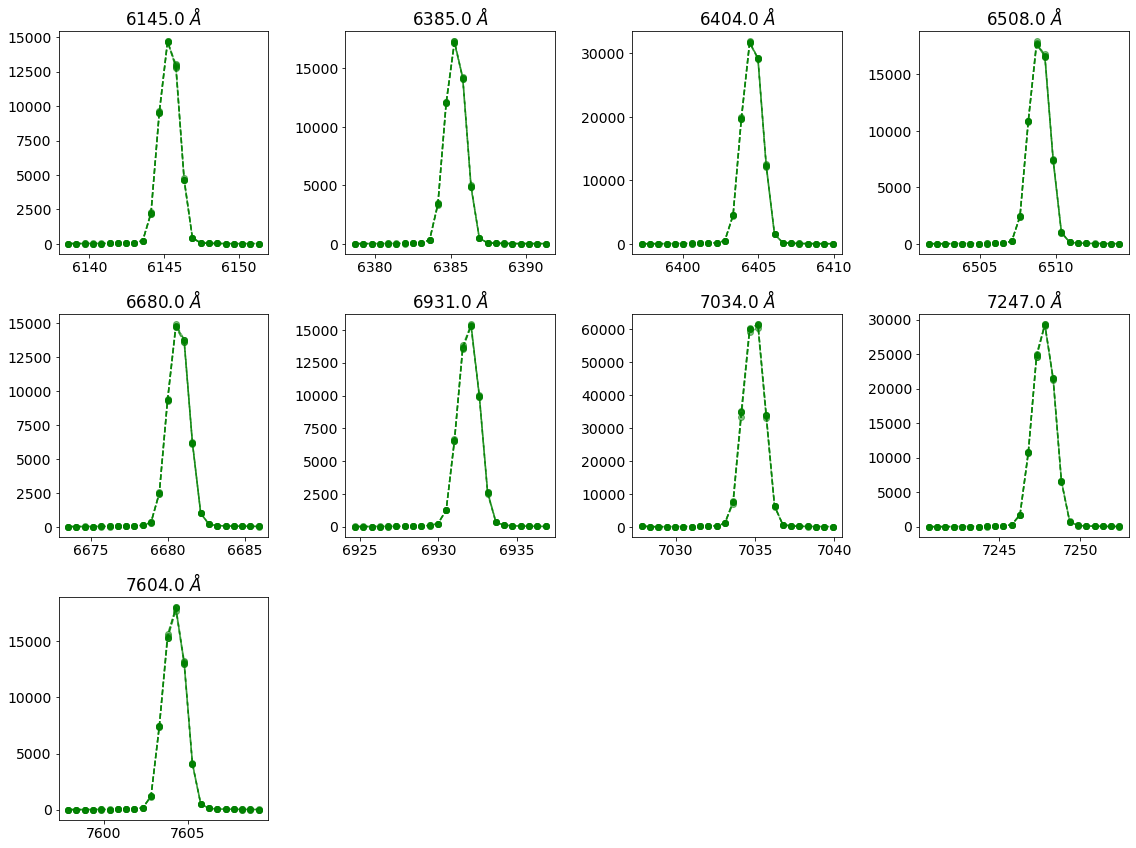

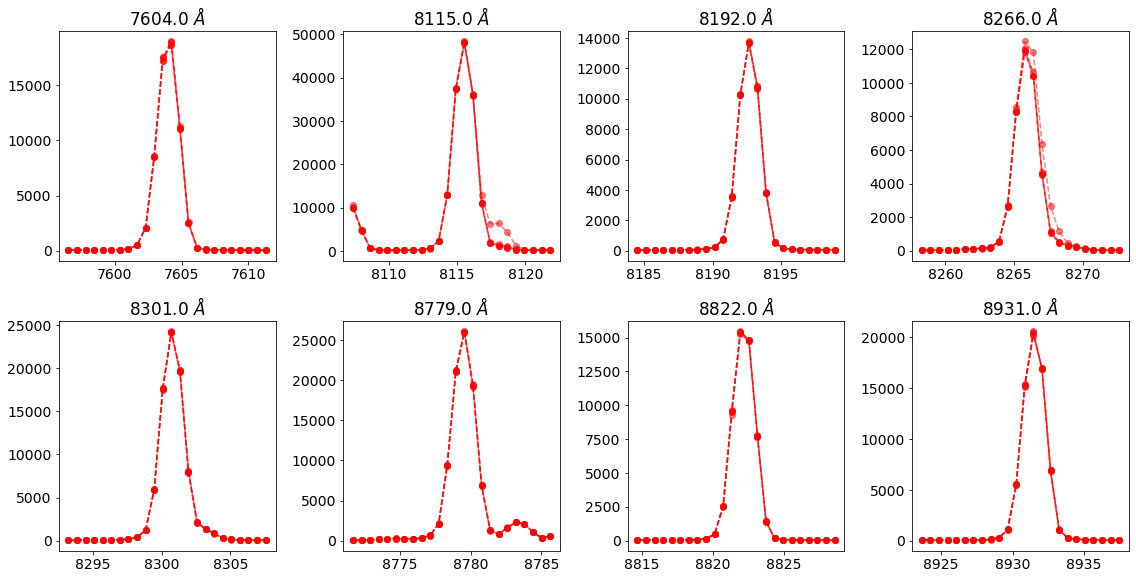

In [5]:
program = 'CALIB short Arcs all'

lpeqw = plot_arc_lines('/global/cfs/cdirs/desi/spectro/nightwatch/nersc',
                       20230104, [161940,161941,161942,161943,161944], 0,
                       prog=program,
                       wavelengths=calarcs[program]['wavelength']);

## Long Arcs

### Data from 20230105

  3611.9    11083.9
  4679.0    37135.0
  4800.8    89958.0
  5086.9   118649.0
  6440.0    52957.1
  8233.9    65247.6
  8283.3    31077.9
  8821.9   177596.6
  8954.8    29479.2
  9048.2    44527.3
  9164.9    59657.6
  9802.0    65993.1

  3611.9    11025.7
  4679.0    37157.9
  4800.8    89955.8
  5086.9   119002.1
  6440.0    52679.2
  8233.9    65288.1
  8283.3    31053.1
  8821.9   177972.4
  8954.8    29654.2
  9048.2    44592.2
  9164.9    59560.7
  9802.0    65816.6

  3611.9    11071.9
  4679.0    37437.4
  4800.8    90130.6
  5086.9   119322.6
  6440.0    53036.9
  8233.9    65358.1
  8283.3    30889.0
  8821.9   178153.6
  8954.8    29667.1
  9048.2    44442.0
  9164.9    59448.2
  9802.0    65903.7

  3611.9    11130.5
  4679.0    37406.8
  4800.8    90117.6
  5086.9   118828.4
  6440.0    53394.9
  8233.9    65241.7
  8283.3    30933.3
  8821.9   177829.6
  8954.8    29739.7
  9048.2    44486.8
  9164.9    59761.5
  9802.0    65824.8

  3611.9    10997.0
  4679.0    3709

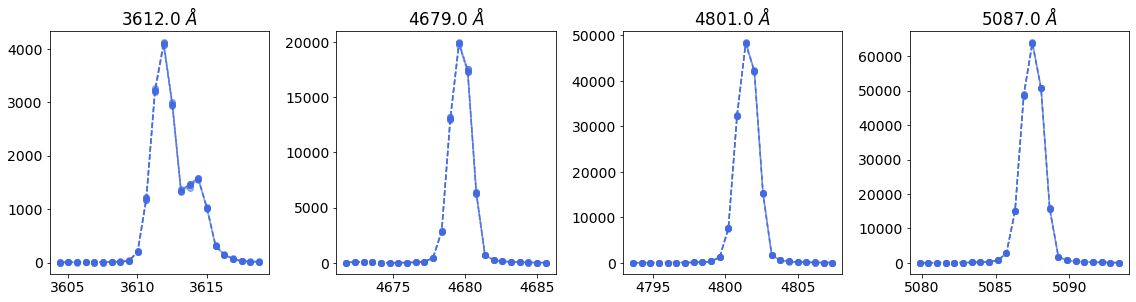

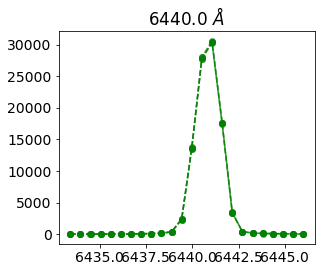

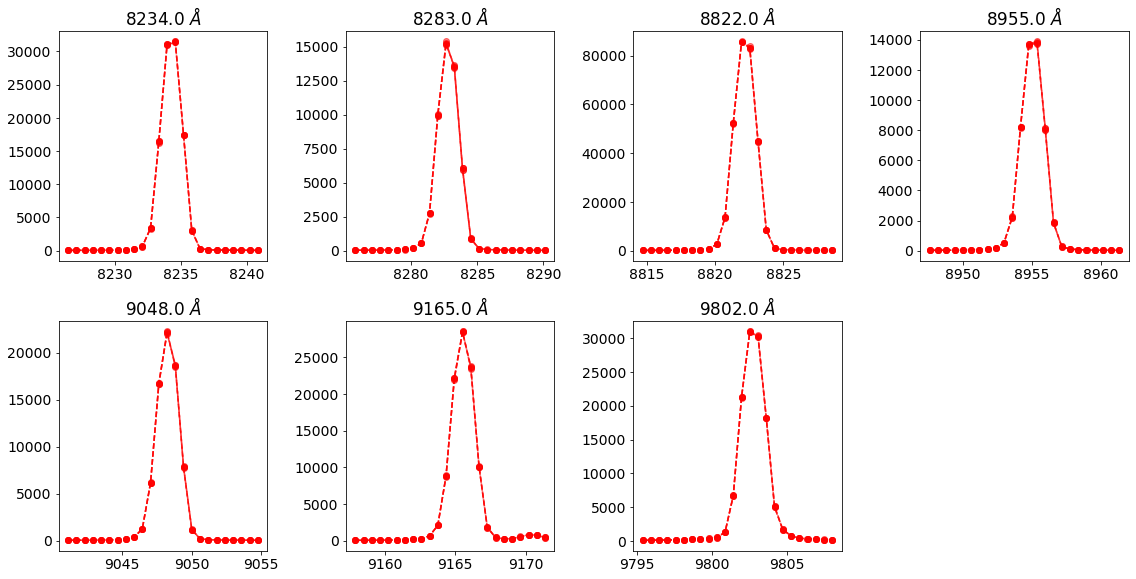

In [6]:
program = 'CALIB long Arcs Cd+Xe'

lpeqw = plot_arc_lines('/global/cfs/cdirs/desi/spectro/nightwatch/nersc',
                       20230105, [162120,162121,162122,162123,162124], 0,
                       prog=program,
                       wavelengths=calarcs[program]['wavelength'])

### Data from 20230106

  3611.9    10849.9
  4679.0    36740.9
  4800.8    88952.3
  5086.9   117477.4
  6440.0    52823.7
  8233.9    64885.1
  8283.3    30549.4
  8821.9   176446.0
  8954.8    29351.2
  9048.2    44056.3
  9164.9    58974.8
  9802.0    65366.0

  3611.9    10909.2
  4679.0    36741.2
  4800.8    89045.5
  5086.9   117155.8
  6440.0    52620.1
  8233.9    64782.7
  8283.3    30599.6
  8821.9   176085.7
  8954.8    29344.0
  9048.2    44161.1
  9164.9    59111.2
  9802.0    65244.9

  3611.9    10875.0
  4679.0    36836.7
  4800.8    88999.9
  5086.9   117528.5
  6440.0    52825.4
  8233.9    64848.4
  8283.3    30576.5
  8821.9   176189.4
  8954.8    29331.4
  9048.2    44117.1
  9164.9    58786.3
  9802.0    65044.0

  3611.9    10779.2
  4679.0    36760.0
  4800.8    89143.1
  5086.9   117770.2
  6440.0    53004.0
  8233.9    64613.6
  8283.3    30724.5
  8821.9   176036.8
  8954.8    29409.0
  9048.2    44074.6
  9164.9    58943.1
  9802.0    65044.2

  3611.9    10767.1
  4679.0    3684

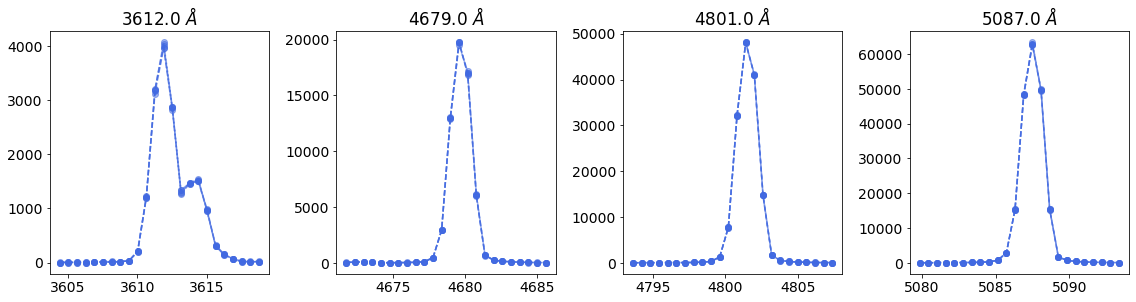

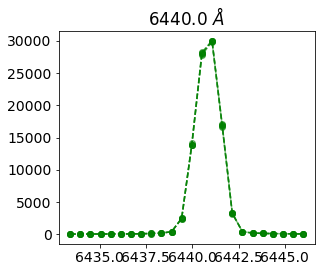

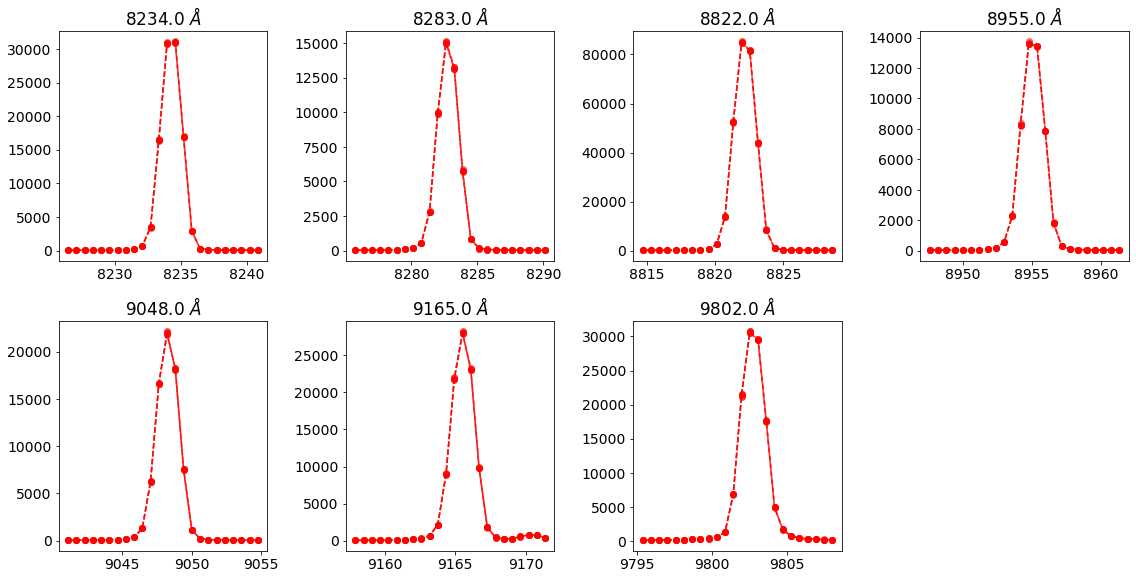

In [7]:
lpeqw = plot_arc_lines('/global/cfs/cdirs/desi/spectro/nightwatch/nersc',
                       20230106, [162208,162209,162210,162211,162212], 0,
                       prog=program,
                       wavelengths=calarcs[program]['wavelength'])